In [1]:
# (1) Import the required Python dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.context import SparkContext
from pyspark.sql import SparkSession  #Main entry point for DataFrame and SQL functionality.
from pyspark.sql import DataFrame #A distributed collection of data grouped into named columns.
from pyspark.sql import Column #A column expression in a DataFrame.
from pyspark.sql import Row #A row of data in a DataFrame.
from pyspark.sql import GroupedData #Aggregation methods, returned by DataFrame.groupBy().
from pyspark.sql import DataFrameNaFunctions #Methods for handling missing data (null values).
from pyspark.sql import DataFrameStatFunctions #Methods for statistics functionality.
from pyspark.sql import functions #List of built-in functions available for DataFrame.
from pyspark.sql import types #List of data types available.
from pyspark.sql import Window #For working with window functions.
from pyspark import SparkConf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.sql.functions import explode
from pyspark.sql.functions import row_number, monotonically_increasing_id
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import when

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:120% !important; }</style>"))



#Linear Regression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

#logistic Regression
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

#decision tree
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Support Vector Machines Classifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.linalg import Vector


#Multilayer Perceptron classifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sc = SparkContext.getOrCreate()
#print(sc.version)

spark = SparkSession.builder.getOrCreate()
print(spark.version)

2.4.8


In [2]:
# (2) Instantiate a Spark Context
conf = SparkConf().setMaster("spark://master:7077").setAppName("ML Models - Marriage Fraud")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [3]:
#Read marriage fraud parquet file
marriage_df = spark.read.parquet("marriage_fraud_dataset.parquet")


marriage_df.createOrReplaceTempView("MarriageFraudTable")

print(marriage_df.count())
marriage_df.printSchema()

1000000
root
 |-- id: long (nullable = true)
 |-- Age_gap: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Number_of_children: integer (nullable = true)
 |-- Number_of_divorce: integer (nullable = true)
 |-- Different_Language: integer (nullable = true)
 |-- Different_Address: integer (nullable = true)
 |-- Criminal_history: integer (nullable = true)
 |-- Big_age_gap: string (nullable = true)
 |-- Too_many_children: string (nullable = true)
 |-- Too_many_divorce: string (nullable = true)
 |-- Too_low_income: string (nullable = true)
 |-- Indicator_Sum: double (nullable = true)
 |-- Fraud_Alert: string (nullable = true)



In [4]:
marriage_df.groupBy('Fraud_Alert').count().show()

+-----------+------+
|Fraud_Alert| count|
+-----------+------+
|          0|893937|
|          1|106063|
+-----------+------+



In [5]:
# (3) Load the dataset into a Spark DataFrame
indexer = StringIndexer(inputCol = "Fraud_Alert", outputCol = "label").fit(marriage_df)
marriage_df = indexer.transform(marriage_df)
marriage_df.show(20)

+------+-------+------+------------------+-----------------+------------------+-----------------+----------------+-----------+-----------------+----------------+--------------+-------------+-----------+-----+
|    id|Age_gap|Income|Number_of_children|Number_of_divorce|Different_Language|Different_Address|Criminal_history|Big_age_gap|Too_many_children|Too_many_divorce|Too_low_income|Indicator_Sum|Fraud_Alert|label|
+------+-------+------+------------------+-----------------+------------------+-----------------+----------------+-----------+-----------------+----------------+--------------+-------------+-----------+-----+
|258922|      2| 42260|                 2|                3|                 0|                0|               0|          0|                0|               0|             0|          0.0|          0|  0.0|
|258923|     10|102590|                 3|                1|                 0|                0|               0|          0|                0|               0|   

In [6]:
# (5) Generate Input Feature Vectors from the Raw Spark DataFrame
feature_columns = ['Age_gap', 'Income', 'Number_of_children', 'Number_of_divorce', 'Different_Language', 'Different_Address', 'Criminal_history']
label_column = 'label'
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
marriage_features_df = vector_assembler.transform(marriage_df).select(['features', label_column])
marriage_features_df.head(10)

[Row(features=DenseVector([2.0, 42260.0, 2.0, 3.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([10.0, 102590.0, 3.0, 1.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=SparseVector(7, {0: 20.0, 1: 181359.0, 2: 3.0}), label=0.0),
 Row(features=DenseVector([1.0, 33308.0, 1.0, 2.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([8.0, 92039.0, 1.0, 1.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=SparseVector(7, {0: 19.0, 1: 169838.0, 2: 2.0}), label=0.0),
 Row(features=SparseVector(7, {0: 4.0, 1: 60741.0, 3: 3.0}), label=0.0),
 Row(features=DenseVector([13.0, 125237.0, 2.0, 2.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([12.0, 117408.0, 1.0, 3.0, 0.0, 0.0, 0.0]), label=0.0),
 Row(features=DenseVector([3.0, 48819.0, 1.0, 1.0, 0.0, 0.0, 0.0]), label=0.0)]

In [7]:
# (6) Split the Raw DataFrame into a Training DataFrame and a Test DataFrame
train_df, test_df = marriage_features_df.randomSplit([0.70, 0.30], seed=552)
train_df.count(), test_df.count()

(700444, 299556)

In [8]:
# (7) Train a Logistic Regression Model on the Training DataFrame
logistic_regression = LogisticRegression(featuresCol = 'features', labelCol = label_column)
logistic_regression_model = logistic_regression.fit(train_df)

In [9]:
# (8) Output Logistic Regression Model Summary Statistics to evaluate the Training Model
print("Model Coefficients: " + str(logistic_regression_model.coefficientMatrix))
print("Intercept: " + str(logistic_regression_model.interceptVector))

Model Coefficients: DenseMatrix([[ 3.93066343e-01, -4.76000923e-05,  5.79626254e-01,
               5.84227651e-01,  6.21236203e+01,  1.93147505e+01,
               2.04835832e+01]])
Intercept: [-22.44394691022355]


In [10]:
# (9) Apply the Trained Logistic Regression Model to the Test DataFrame to make predictions
test_logistic_regression_predictions_df = logistic_regression_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_logistic_regression_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show()

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+--------------------+----------+-----+--------------------+
|         probability|       rawPrediction|prediction|label|            features|
+--------------------+--------------------+----------+-----+--------------------+
|[0.99999999991659...|[23.2072772110870...|       0.0|  0.0|(7,[0,1],[1.0,242...|
|[0.99999999991677...|[23.2094192152425...|       0.0|  0.0|(7,[0,1],[1.0,243...|
|[0.99999999991737...|[23.2166544292786...|       0.0|  0.0|(7,[0,1],[1.0,244...|
|[0.99999999991762...|[23.2197484352809...|       0.0|  0.0|(7,[0,1],[1.0,245...|
|[0.99999999991962...|[23.2443100829299...|       0.0|  0.0|(7,[0,1],[1.0,250...|
|[0.99999999991997...|[23.2487368915179...|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99999999992007...|[23.2498792937341...|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99999999992092...|[23.2606369146036...|       0.0|  0.0|(7,[0,1],[1.0,254...|
|[0.99999999992119...|[23.2640641212523...|       

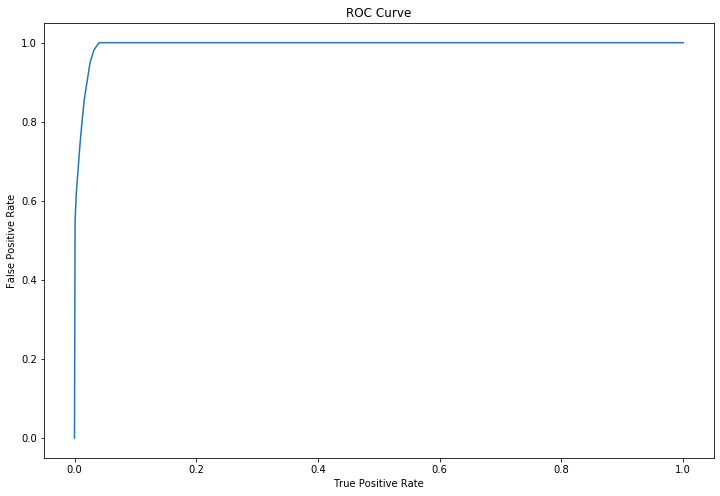

Area Under ROC Curve on Test Data = 0.994246


In [11]:
# (10) Evaluate the performance of our Logistic Regression Model on the Test DataFrame using Area under a ROC curve
test_summary = logistic_regression_model.evaluate(test_df)
roc = test_summary.roc.toPandas()
plt.figure(figsize=(12,8))
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
evaluator_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_roc_area.evaluate(test_logistic_regression_predictions_df))

In [12]:
# Calculate Logistic model metrics
N = test_logistic_regression_predictions_df.count()
true_positives = test_logistic_regression_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 1.0 ).count()
true_negatives = test_logistic_regression_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 0.0 ).count()
false_positives = test_logistic_regression_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 0.0 ).count()
false_negatives = test_logistic_regression_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 1.0 ).count()
print("Number of Test record = %g" % N)
print("Overall Accuracy = %g" % ((true_negatives + true_positives)/N))
print("Overall Error Rate = %g" % ((false_negatives + false_positives)/N))
print("Sensitivity = %g" % (true_positives / (true_positives + false_negatives)))
print("Specificity = %g" % (true_negatives / (true_negatives + false_positives)))
print("Precision Score = %g" % (true_positives/(true_positives + false_positives)))
print("Recall Score = %g" % (true_positives/(true_positives + false_negatives)))
print("F1 Score = %g" % (2*true_positives/(2*true_positives + false_negatives + false_positives)))

Number of Test record = 299556
Overall Accuracy = 0.971074
Overall Error Rate = 0.0289261
Sensitivity = 0.89173
Specificity = 0.980522
Precision Score = 0.844992
Recall Score = 0.89173
F1 Score = 0.867732


In [13]:
# Calculate Confustion Matrix
predictions_and_label = test_logistic_regression_predictions_df.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictions_and_label)
print("N = %g" % N)
print(metrics.confusionMatrix())

N = 299556
DenseMatrix([[262468.,   5214.],
             [  3451.,  28423.]])


In [14]:
##DECISION TREE AND RANDOM FOREST

In [15]:
%%time
# (7) Train a Classification Tree Model on the Training DataFrame
decision_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = label_column)
decision_tree_model = decision_tree.fit(train_df)

Wall time: 14.6 s


In [16]:
# (8) Apply the Trained Classification Tree Model to the Test DataFrame to make predictions
test_decision_tree_predictions_df = decision_tree_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_decision_tree_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show()

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+----------------+----------+-----+--------------------+
|         probability|   rawPrediction|prediction|label|            features|
+--------------------+----------------+----------+-----+--------------------+
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,242...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,243...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,244...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,245...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,250...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,254...|
|[0.99906224684347...|[610462.0,573.0]|       0.0|  0.0|(7,[0,1],[1.0,254...|
|[0.999062246843

In [17]:
# Calculate  model metrics
N1 = test_decision_tree_predictions_df.count()
true_positives = test_decision_tree_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 1.0 ).count()
true_negatives = test_decision_tree_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 0.0 ).count()
false_positives = test_decision_tree_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 0.0 ).count()
false_negatives = test_decision_tree_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 1.0 ).count()
print("Number of Test record = %g" % N)
print("Overall Accuracy = %g" % ((true_negatives + true_positives)/N1))
print("Overall Error Rate = %g" % ((false_negatives + false_positives)/N1))
print("Sensitivity = %g" % (true_positives / (true_positives + false_negatives)))
print("Specificity = %g" % (true_negatives / (true_negatives + false_positives)))
print("Precision Score = %g" % (true_positives/(true_positives + false_positives)))
print("Recall Score = %g" % (true_positives/(true_positives + false_negatives)))
print("F1 Score = %g" % (2*true_positives/(2*true_positives + false_negatives + false_positives)))

Number of Test record = 299556
Overall Accuracy = 0.998648
Overall Error Rate = 0.001352
Sensitivity = 0.987294
Specificity = 1
Precision Score = 1
Recall Score = 0.987294
F1 Score = 0.993606


In [18]:
# (9) Evaluate the performance of our Classification Tree Model on the Test DataFrame using Area under a ROC curve
evaluator_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_roc_area.evaluate(test_decision_tree_predictions_df))

Area Under ROC Curve on Test Data = 0.99114


In [19]:
# (10) Visualise the Classification Tree
print(str(decision_tree_model.toDebugString))

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_9be91ece785a) of depth 5 with 11 nodes
  If (feature 4 <= 0.5)
   If (feature 3 <= 4.5)
    If (feature 2 <= 5.5)
     If (feature 5 <= 0.5)
      Predict: 0.0
     Else (feature 5 > 0.5)
      If (feature 0 <= 20.5)
       Predict: 0.0
      Else (feature 0 > 20.5)
       Predict: 1.0
    Else (feature 2 > 5.5)
     Predict: 1.0
   Else (feature 3 > 4.5)
    Predict: 1.0
  Else (feature 4 > 0.5)
   Predict: 1.0



In [20]:
# (11) Train a Random Forest Classifier Model on the Training DataFrame
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = label_column)
random_forest_model = random_forest.fit(train_df)

In [21]:
# (12) Apply the Trained Random Forest Classifier Model to the Test DataFrame to make predictions
test_random_forest_predictions_df = random_forest_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_random_forest_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show()

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+--------------------+----------+-----+--------------------+
|         probability|       rawPrediction|prediction|label|            features|
+--------------------+--------------------+----------+-----+--------------------+
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,242...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,243...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,244...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,245...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,250...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,251...|
|[0.99677419238406...|[19.9354838476812...|       0.0|  0.0|(7,[0,1],[1.0,254...|
|[0.99677419238406...|[19.9354838476812...|       

In [22]:
# (13) Evaluate the performance of our Random Forest Classifier Model on the Test DataFrame using Area under a ROC curve
evaluator_rf_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_rf_roc_area.evaluate(test_random_forest_predictions_df))

Area Under ROC Curve on Test Data = 0.99993


In [23]:
# Calculate Random Forest model metrics
N2 = test_random_forest_predictions_df.count()
true_positives = test_random_forest_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 1.0 ).count()
true_negatives = test_random_forest_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 0.0 ).count()
false_positives = test_random_forest_predictions_df.filter( col("prediction") == 1.0 ).filter( col("label") == 0.0 ).count()
false_negatives = test_random_forest_predictions_df.filter( col("prediction") == 0.0 ).filter( col("label") == 1.0 ).count()
print("Number of Test records = %g" % N)
print("Overall Accuracy = %g" % ((true_negatives + true_positives)/N2))
print("Overall Error Rate = %g" % ((false_negatives + false_positives)/N2))
print("Sensitivity = %g" % (true_positives / (true_positives + false_negatives)))
print("Specificity = %g" % (true_negatives / (true_negatives + false_positives)))
print("Precision Score = %g" % (true_positives/(true_positives + false_positives)))
print("Recall Score = %g" % (true_positives/(true_positives + false_negatives)))
print("F1 Score = %g" % (2*true_positives/(2*true_positives + false_negatives + false_positives)))

Number of Test records = 299556
Overall Accuracy = 0.999259
Overall Error Rate = 0.000741097
Sensitivity = 0.993035
Specificity = 1
Precision Score = 1
Recall Score = 0.993035
F1 Score = 0.996505


In [24]:
%%time
# Linear Support Vector Machines Classifier
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC()
lsvc_model = lsvc.fit(train_df)
model_predictions = lsvc_model.transform(test_df)
model_predictions.columns

Wall time: 17min 14s


['features', 'label', 'rawPrediction', 'prediction']

In [25]:
model_predictions.select(['label','prediction']).show(20, False)

+-----+----------+
|label|prediction|
+-----+----------+
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 20 rows



In [26]:
#Evaluate Performance on Test Data
svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
svc_auroc = svc_evaluator.evaluate(model_predictions)
print(f'The auc value of SupportVectorClassifier is {svc_auroc}')

svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
svc_aupr = svc_evaluator.evaluate(model_predictions)
print(f'The aupr value of SupportVectorClassifier is {svc_aupr}')



The auc value of SupportVectorClassifier is 0.9944575127116344
The aupr value of SupportVectorClassifier is 0.9592819439860784


In [27]:
true_pos = model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos = model_predictions.filter(model_predictions['label']==1).count
pred_pos = model_predictions.filter(model_predictions['prediction']==1).count()




In [28]:
N3 = model_predictions.count()
true_positives = model_predictions.filter( col("prediction") == 1.0 ).filter( col("label") == 1.0 ).count()
true_negatives = model_predictions.filter( col("prediction") == 0.0 ).filter( col("label") == 0.0 ).count()
false_positives = model_predictions.filter( col("prediction") == 1.0 ).filter( col("label") == 0.0 ).count()
false_negatives = model_predictions.filter( col("prediction") == 0.0 ).filter( col("label") == 1.0 ).count()
print("Number of Test record = %g" % N)
print("Overall Accuracy = %g" % ((true_negatives + true_positives)/N3))
print("Overall Error Rate = %g" % ((false_negatives + false_positives)/N3))
print("Sensitivity = %g" % (true_positives / (true_positives + false_negatives)))
print("Specificity = %g" % (true_negatives / (true_negatives + false_positives)))
print("Precision Score = %g" % (true_positives/(true_positives + false_positives)))
print("Recall Score = %g" % (true_positives/(true_positives + false_negatives)))
print("F1 Score = %g" % (2*true_positives/(2*true_positives + false_negatives + false_positives)))

Number of Test record = 299556
Overall Accuracy = 0.964531
Overall Error Rate = 0.0354692
Sensitivity = 0.868608
Specificity = 0.975953
Precision Score = 0.811359
Recall Score = 0.868608
F1 Score = 0.839008


In [97]:
num_children = marriage_df.groupBy('Fraud_Alert','Number_of_children').count()

In [98]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType
num_children = num_children.selectExpr("cast(Number_of_children as string) Number_of_children",
                                      "cast(count as int) count")
num_children.printSchema()
num_children.show()

root
 |-- Number_of_children: string (nullable = true)
 |-- count: integer (nullable = false)

+------------------+------+
|Number_of_children| count|
+------------------+------+
|                 2|195834|
|                 5|  7497|
|                 3|153451|
|                 3| 13846|
|                 2| 17513|
|                 0| 11614|
|                 4| 10004|
|                 0|130585|
|                 1| 21647|
|                 4|109100|
|                 1|240960|
|                 5| 64007|
|                 6| 23942|
+------------------+------+

